In [40]:
from math import sqrt
import numpy as np
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import read_csv
from datetime import datetime
from keras.layers import Bidirectional
import datetime
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from numpy import array

In [41]:
def rmse(pred, actual):
    error = np.subtract(pred, actual)
    sqerror= np.sum(np.square(error))/actual.shape[0]
    return np.sqrt(sqerror)

In [42]:
def MODEL_FNN_adam(x_train,x_test,y_train,y_test):
    train_acc=np.zeros(30)
    test_acc=np.zeros(30)
    Step_RMSE=np.zeros([30,10])
    for run in range(30):
        mlp_adam = MLPRegressor(hidden_layer_sizes=(5,), activation='relu', solver='adam', alpha=0.1,max_iter=1000, tol=0)
        mlp_adam.fit(x_train, y_train)
        y_predicttrain = mlp_adam.predict(x_train)
        y_predicttest = mlp_adam.predict(x_test)
        train_acc[run] = rmse( y_predicttrain, y_train) 
        test_acc[run] = rmse( y_predicttest, y_test)
        for j in range(10):
            Step_RMSE[run][j]=rmse(y_predicttest[j], y_test[j])
    return train_acc,test_acc,Step_RMSE

def MODEL_FNN_sgd(x_train,x_test,y_train,y_test):
    train_acc=np.zeros(30)
    test_acc=np.zeros(30)
    Step_RMSE=np.zeros([30,10])
    for run in range(30):
        mlp_sgd = MLPRegressor(hidden_layer_sizes=(5, ), activation='relu', solver='sgd', alpha=0.1,max_iter=1000, tol=0)
        mlp_sgd.fit(x_train,y_train)
        y_predicttrain = mlp_sgd.predict(x_train)
        y_predicttest = mlp_sgd.predict(x_test)
        train_acc[run] = rmse( y_predicttrain,y_train) 
        test_acc[run] = rmse( y_predicttest, y_test) 
        for j in range(10):
            Step_RMSE[run][j]=rmse(y_predicttest[j], y_test[j])
    return train_acc,test_acc,Step_RMSE


def MODEL_LSTM(x_train,x_test,y_train,y_test):
    n_features = 1
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
    print(x_train.shape)
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))
    print(x_test.shape)
    
    train_acc=np.zeros(30)
    test_acc=np.zeros(30)
    Step_RMSE=np.zeros([30,10])
    
    model = Sequential()
    model.add(LSTM(10, activation='relu', return_sequences=True, input_shape=(5,n_features)))
    model.add(LSTM(10, activation='relu'))
    model.add(Dense(10))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    
    for run in range(30):
        print("Experiment",run,"in progress")
        # fit model
        model.fit(x_train, y_train, epochs=1000,batch_size=64, verbose=0, shuffle=False)
        y_predicttrain = model.predict(x_train, verbose=0)
        y_predicttest = model.predict(x_test, verbose=0)
        train_acc[run] = rmse( y_predicttrain,y_train) 
        test_acc[run] = rmse( y_predicttest, y_test) 
        for j in range(10):
            Step_RMSE[run][j]=rmse(y_predicttest[j], y_test[j])
    return train_acc,test_acc,Step_RMSE


def MODEL_Bi_LSTM(x_train,x_test,y_train,y_test):
    n_features = 1
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
    print(x_train.shape)
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))
    print(x_test.shape)
    
    train_acc=np.zeros(30)
    test_acc=np.zeros(30)
    Step_RMSE=np.zeros([30,10])
    
    model = Sequential()
    model.add(Bidirectional(LSTM(10, activation='relu'), input_shape=(5,n_features)))
    model.add(Dense(10))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    
    for run in range(30):
        print("Experiment",run,"in progress")
        # fit model
        model.fit(x_train, y_train, epochs=1000,batch_size=64, verbose=0, shuffle=False)
        y_predicttrain = model.predict(x_train, verbose=0)
        y_predicttest = model.predict(x_test, verbose=0)
        train_acc[run] = rmse( y_predicttrain,y_train) 
        test_acc[run] = rmse( y_predicttest, y_test) 
        for j in range(10):
            Step_RMSE[run][j]=rmse(y_predicttest[j], y_test[j])
    return train_acc,test_acc,Step_RMSE


def MODEL_EN_DC(x_train,x_test,y_train,y_test):
    n_features = 1
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
    print(x_train.shape)
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))
    print(x_test.shape)
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
    print(y_train.shape)
    y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
    print(y_test.shape)
    
    train_acc=np.zeros(30)
    test_acc=np.zeros(30)
    Step_RMSE=np.zeros([30,10])
    
    model = Sequential()
    model.add(LSTM(10, activation='relu',input_shape=(5,n_features)))
    model.add(RepeatVector(10))
    model.add(LSTM(10, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(10, activation='relu')))
    model.add(TimeDistributed(Dense(1)))

    model.compile(optimizer='adam', loss='mse')
    model.summary()
        
    for run in range(30):
        print("Experiment",run,"in progress")
        # fit model
        model.fit(x_train, y_train, epochs=1000,batch_size=64, verbose=0, shuffle=False)
        y_predicttrain = model.predict(x_train, verbose=0)
        y_predicttest = model.predict(x_test, verbose=0)
        train_acc[run] = rmse( y_predicttrain,y_train) 
        test_acc[run] = rmse( y_predicttest, y_test) 
        for j in range(10):
            Step_RMSE[run][j]=rmse(y_predicttest[j], y_test[j])
    return train_acc,test_acc,Step_RMSE



Lazer


/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.p

MODEL_FNN_adam
       TrainRMSE  TestRMSE
Exp1    0.656578  0.466319
Exp2    0.647585  0.469269
Exp3    0.681402  0.467691
Exp4    0.734378  0.539870
Exp5    0.870460  0.688446
Exp6    0.618971  0.427112
Exp7    0.817564  0.626321
Exp8    0.769606  0.586941
Exp9    0.618880  0.393416
Exp10   0.697619  0.495563
Exp11   1.121622  1.020908
Exp12   0.933092  0.749858
Exp13   0.622348  0.399975
Exp14   0.716743  0.555630
Exp15   0.771830  0.606104
Exp16   0.652861  0.455909
Exp17   0.607340  0.418720
Exp18   0.614748  0.410577
Exp19   0.600503  0.404894
Exp20   0.736760  0.554281
Exp21   0.698157  0.480080
Exp22   0.691150  0.487266
Exp23   0.662655  0.463612
Exp24   0.716420  0.552681
Exp25   0.684002  0.473219
Exp26   0.800156  0.602121
Exp27   0.937669  0.822700
Exp28   0.735767  0.517214
Exp29   0.719254  0.565176
Exp30   0.515310  0.365250
                Mean  Standard Deviation       Min       Max
TrainRMSE   0.721714            0.119731  0.515310  1.121622
TestRMSE    0.535571      

/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.p

MODEL_FNN_sgd
       TrainRMSE  TestRMSE
Exp1    0.606455  0.384390
Exp2    0.599583  0.405955
Exp3    0.653090  0.432351
Exp4    0.670865  0.447897
Exp5    0.589233  0.388885
Exp6    0.682876  0.454496
Exp7    0.613526  0.406742
Exp8    0.621700  0.405713
Exp9    0.710128  0.482200
Exp10   0.650385  0.436344
Exp11   0.672402  0.445620
Exp12   0.603160  0.380485
Exp13   0.647167  0.418595
Exp14   0.629592  0.416271
Exp15   0.668885  0.420928
Exp16   0.677285  0.443267
Exp17   0.648927  0.429326
Exp18   0.656989  0.428389
Exp19   0.636087  0.415869
Exp20   0.652768  0.440688
Exp21   0.626321  0.414724
Exp22   0.639294  0.431009
Exp23   0.636930  0.419056
Exp24   0.599316  0.389564
Exp25   0.669017  0.443076
Exp26   0.620851  0.414644
Exp27   0.662660  0.445930
Exp28   0.650790  0.430237
Exp29   0.652647  0.432101
Exp30   0.671463  0.448422
                Mean  Standard Deviation       Min       Max
TrainRMSE   0.644013            0.028317  0.589233  0.710128
TestRMSE    0.425106       

Experiment 1 in progress
Experiment 2 in progress
Experiment 3 in progress
Experiment 4 in progress
Experiment 5 in progress
Experiment 6 in progress
Experiment 7 in progress
Experiment 8 in progress
Experiment 9 in progress
Experiment 10 in progress
Experiment 11 in progress
Experiment 12 in progress
Experiment 13 in progress
Experiment 14 in progress
Experiment 15 in progress
Experiment 16 in progress
Experiment 17 in progress
Experiment 18 in progress
Experiment 19 in progress
Experiment 20 in progress
Experiment 21 in progress
Experiment 22 in progress
Experiment 23 in progress
Experiment 24 in progress
Experiment 25 in progress
Experiment 26 in progress
Experiment 27 in progress
Experiment 28 in progress
Experiment 29 in progress
MODEL_EN_DC
       TrainRMSE  TestRMSE
Exp1    0.670271  0.455549
Exp2    0.655613  0.434916
Exp3    0.652009  0.430211
Exp4    0.649946  0.427785
Exp5    0.648209  0.426511
Exp6    0.645588  0.424884
Exp7    0.639458  0.422176
Exp8    0.630980  0.422102


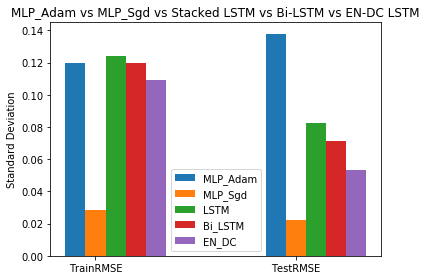

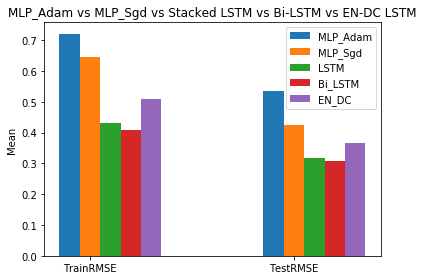

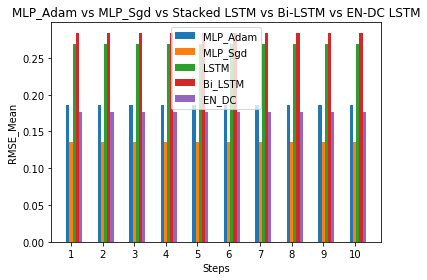

Sunspot


/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.p

MODEL_FNN_adam
       TrainRMSE  TestRMSE
Exp1    0.858002  0.656230
Exp2    1.369758  0.993593
Exp3    0.720019  0.609242
Exp4    0.704761  0.589128
Exp5    0.748309  0.631472
Exp6    0.679849  0.708001
Exp7    0.599747  0.439370
Exp8    0.768022  0.710952
Exp9    0.998485  0.743239
Exp10   0.573920  0.522821
Exp11   0.564979  0.469456
Exp12   0.753855  0.618054
Exp13   0.662352  0.569284
Exp14   0.569236  0.506124
Exp15   0.686611  0.651338
Exp16   0.761929  0.628316
Exp17   0.507706  0.409264
Exp18   0.868087  0.694275
Exp19   0.540299  0.490847
Exp20   0.491419  0.428884
Exp21   0.791044  0.529427
Exp22   0.591834  0.507681
Exp23   0.443889  0.365868
Exp24   1.068722  0.714752
Exp25   0.964478  0.870038
Exp26   0.472802  0.372128
Exp27   0.866811  0.679776
Exp28   0.886505  0.815026
Exp29   0.538372  0.445225
Exp30   0.631084  0.447136
                Mean  Standard Deviation       Min       Max
TrainRMSE   0.722763            0.199609  0.443889  1.369758
TestRMSE    0.593898      

/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.p

MODEL_FNN_sgd
       TrainRMSE  TestRMSE
Exp1    0.498265  0.447321
Exp2    0.728619  0.610126
Exp3    0.474857  0.436457
Exp4    0.501672  0.478082
Exp5    0.552170  0.483826
Exp6    0.539955  0.493526
Exp7    0.732700  0.650395
Exp8    0.664968  0.621986
Exp9    0.625135  0.579314
Exp10   0.457014  0.393263
Exp11   0.511631  0.459280
Exp12   0.664130  0.560282
Exp13   0.540479  0.523925
Exp14   0.482357  0.422619
Exp15   0.675384  0.617129
Exp16   0.743373  0.601049
Exp17   0.602396  0.567261
Exp18   0.499185  0.459733
Exp19   0.549832  0.486432
Exp20   0.743243  0.590490
Exp21   0.435814  0.368585
Exp22   0.464228  0.424306
Exp23   0.669586  0.620359
Exp24   0.505547  0.438095
Exp25   0.416724  0.367668
Exp26   0.380851  0.312674
Exp27   0.616692  0.533183
Exp28   0.625118  0.551122
Exp29   0.384687  0.302583
Exp30   0.640951  0.564836
                Mean  Standard Deviation       Min       Max
TrainRMSE   0.564252            0.106638  0.380851  0.743373
TestRMSE    0.498864       

Experiment 1 in progress
Experiment 2 in progress
Experiment 3 in progress
Experiment 4 in progress
Experiment 5 in progress
Experiment 6 in progress
Experiment 7 in progress
Experiment 8 in progress
Experiment 9 in progress
Experiment 10 in progress
Experiment 11 in progress
Experiment 12 in progress
Experiment 13 in progress
Experiment 14 in progress
Experiment 15 in progress
Experiment 16 in progress
Experiment 17 in progress
Experiment 18 in progress
Experiment 19 in progress
Experiment 20 in progress
Experiment 21 in progress
Experiment 22 in progress
Experiment 23 in progress
Experiment 24 in progress
Experiment 25 in progress
Experiment 26 in progress
Experiment 27 in progress
Experiment 28 in progress
Experiment 29 in progress
MODEL_EN_DC
       TrainRMSE  TestRMSE
Exp1    1.059540  0.574485
Exp2    0.632510  0.530729
Exp3    0.541909  0.434106
Exp4    0.478445  0.329385
Exp5    0.433789  0.288723
Exp6    0.407225  0.275337
Exp7    0.397247  0.268834
Exp8    0.389559  0.263144


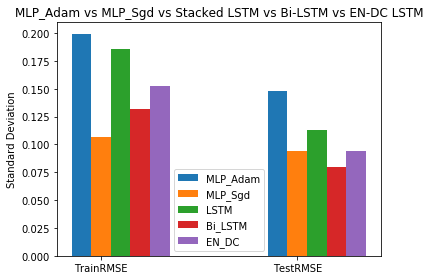

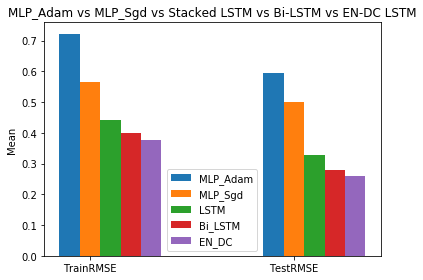

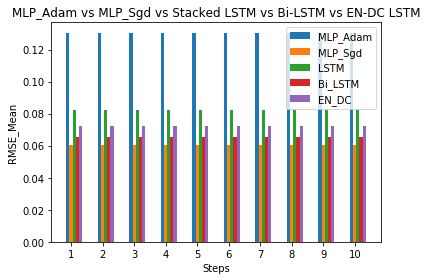

Mackey


/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.p

MODEL_FNN_adam
       TrainRMSE  TestRMSE
Exp1    0.389102  0.390847
Exp2    0.519639  0.521540
Exp3    0.847834  0.847419
Exp4    0.280943  0.282932
Exp5    0.582292  0.583630
Exp6    0.637944  0.638069
Exp7    0.647031  0.649278
Exp8    0.362741  0.364812
Exp9    0.418597  0.420176
Exp10   0.568515  0.568981
Exp11   0.586887  0.588117
Exp12   0.480088  0.480542
Exp13   0.472491  0.473707
Exp14   1.139524  1.138678
Exp15   1.202314  1.200974
Exp16   0.548180  0.548864
Exp17   0.523789  0.525180
Exp18   1.328076  1.326460
Exp19   0.319692  0.322295
Exp20   1.010891  1.011450
Exp21   0.422868  0.424810
Exp22   0.542136  0.543227
Exp23   0.516762  0.518349
Exp24   0.682737  0.682430
Exp25   0.835561  0.834743
Exp26   0.935391  0.934815
Exp27   0.850413  0.849143
Exp28   0.296085  0.298986
Exp29   0.406888  0.410069
Exp30   0.396656  0.399132
                Mean  Standard Deviation       Min       Max
TrainRMSE   0.625069            0.271435  0.280943  1.328076
TestRMSE    0.625988      

/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.p

MODEL_FNN_sgd
       TrainRMSE  TestRMSE
Exp1    0.319889  0.322353
Exp2    0.286741  0.289543
Exp3    0.290299  0.293302
Exp4    0.303420  0.306517
Exp5    0.316956  0.320287
Exp6    0.307434  0.309787
Exp7    0.285532  0.288569
Exp8    0.306792  0.309892
Exp9    0.294091  0.297387
Exp10   0.273973  0.276695
Exp11   0.314492  0.317835
Exp12   0.327386  0.330062
Exp13   0.283798  0.286828
Exp14   0.285397  0.288235
Exp15   0.322395  0.325248
Exp16   0.274795  0.277138
Exp17   0.298680  0.301361
Exp18   0.321969  0.324700
Exp19   0.325046  0.327556
Exp20   0.350424  0.354033
Exp21   0.292274  0.295070
Exp22   0.303639  0.306565
Exp23   0.303845  0.306693
Exp24   0.314731  0.317836
Exp25   0.305700  0.308973
Exp26   0.315724  0.318714
Exp27   0.320833  0.323191
Exp28   0.274227  0.276801
Exp29   0.294917  0.297835
Exp30   0.323007  0.326158
                Mean  Standard Deviation       Min       Max
TrainRMSE   0.304613            0.018087  0.273973  0.350424
TestRMSE    0.307505       

Experiment 1 in progress
Experiment 2 in progress
Experiment 3 in progress
Experiment 4 in progress
Experiment 5 in progress
Experiment 6 in progress
Experiment 7 in progress
Experiment 8 in progress
Experiment 9 in progress
Experiment 10 in progress
Experiment 11 in progress
Experiment 12 in progress
Experiment 13 in progress
Experiment 14 in progress
Experiment 15 in progress
Experiment 16 in progress
Experiment 17 in progress
Experiment 18 in progress
Experiment 19 in progress
Experiment 20 in progress
Experiment 21 in progress
Experiment 22 in progress
Experiment 23 in progress
Experiment 24 in progress
Experiment 25 in progress
Experiment 26 in progress
Experiment 27 in progress
Experiment 28 in progress
Experiment 29 in progress
MODEL_EN_DC
       TrainRMSE  TestRMSE
Exp1    1.157133  1.154897
Exp2    1.018092  1.016008
Exp3    0.890992  0.889097
Exp4    0.776703  0.775039
Exp5    0.675850  0.674469
Exp6    0.588873  0.587833
Exp7    0.515944  0.515308
Exp8    0.456851  0.456674


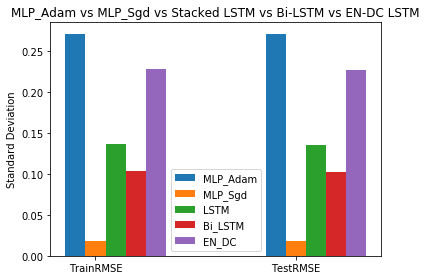

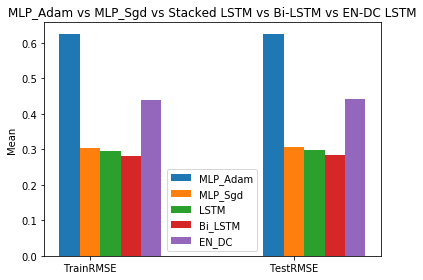

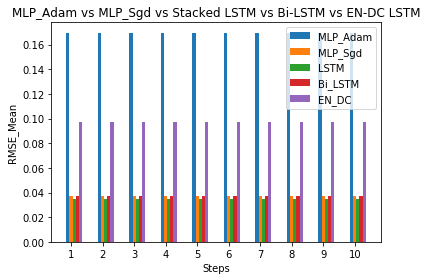

Lorenz


/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.p

MODEL_FNN_adam
       TrainRMSE  TestRMSE
Exp1    1.105165  1.015793
Exp2    1.153847  1.061167
Exp3    0.952402  0.859639
Exp4    0.936282  0.863765
Exp5    0.567063  0.525881
Exp6    0.877413  0.795339
Exp7    0.940541  0.858243
Exp8    0.776191  0.687896
Exp9    0.568807  0.539362
Exp10   0.441662  0.424179
Exp11   0.687036  0.624518
Exp12   0.999770  0.901841
Exp13   0.385342  0.375955
Exp14   0.616383  0.586212
Exp15   0.779325  0.694741
Exp16   0.613368  0.593096
Exp17   1.223291  1.114148
Exp18   1.140266  1.009768
Exp19   0.490062  0.453805
Exp20   0.947498  0.822738
Exp21   0.776118  0.697721
Exp22   0.663151  0.588445
Exp23   0.454025  0.431546
Exp24   0.604356  0.552191
Exp25   0.619285  0.570574
Exp26   0.918163  0.826591
Exp27   0.457346  0.459276
Exp28   0.515436  0.465141
Exp29   0.892086  0.854398
Exp30   0.615977  0.566260
                Mean  Standard Deviation       Min       Max
TrainRMSE   0.757255            0.233719  0.385342  1.223291
TestRMSE    0.694008      

/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.p

MODEL_FNN_sgd
       TrainRMSE  TestRMSE
Exp1    0.369309  0.357413
Exp2    0.676184  0.599696
Exp3    0.535011  0.491289
Exp4    0.513596  0.483549
Exp5    0.317979  0.300679
Exp6    0.666796  0.606709
Exp7    0.601508  0.560877
Exp8    0.639338  0.561771
Exp9    0.476481  0.453172
Exp10   0.489485  0.464384
Exp11   0.661244  0.589201
Exp12   0.518996  0.476223
Exp13   0.403911  0.386213
Exp14   0.591492  0.557902
Exp15   0.425507  0.409839
Exp16   0.554909  0.523430
Exp17   0.519390  0.493936
Exp18   0.375619  0.365547
Exp19   0.508374  0.480416
Exp20   0.466684  0.449949
Exp21   0.449934  0.422669
Exp22   0.404859  0.383977
Exp23   0.660868  0.606631
Exp24   0.476916  0.453985
Exp25   0.418680  0.393452
Exp26   0.548850  0.508130
Exp27   0.509782  0.484192
Exp28   0.443261  0.413818
Exp29   0.556696  0.522265
Exp30   0.528269  0.496037
                Mean  Standard Deviation       Min       Max
TrainRMSE   0.510331            0.093366  0.317979  0.676184
TestRMSE    0.476578       

Experiment 1 in progress
Experiment 2 in progress
Experiment 3 in progress
Experiment 4 in progress
Experiment 5 in progress
Experiment 6 in progress
Experiment 7 in progress
Experiment 8 in progress
Experiment 9 in progress
Experiment 10 in progress
Experiment 11 in progress
Experiment 12 in progress
Experiment 13 in progress
Experiment 14 in progress
Experiment 15 in progress
Experiment 16 in progress
Experiment 17 in progress
Experiment 18 in progress
Experiment 19 in progress
Experiment 20 in progress
Experiment 21 in progress
Experiment 22 in progress
Experiment 23 in progress
Experiment 24 in progress
Experiment 25 in progress
Experiment 26 in progress
Experiment 27 in progress
Experiment 28 in progress
Experiment 29 in progress
MODEL_EN_DC
       TrainRMSE  TestRMSE
Exp1    0.743498  0.625434
Exp2    0.608527  0.562567
Exp3    0.518171  0.474787
Exp4    0.412477  0.374729
Exp5    0.362763  0.340145
Exp6    0.343604  0.325502
Exp7    0.329448  0.314679
Exp8    0.319631  0.307658


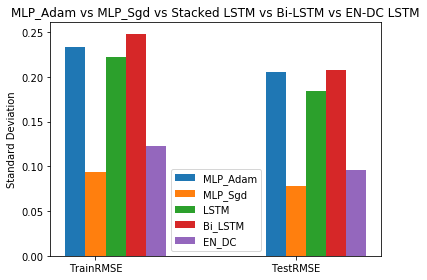

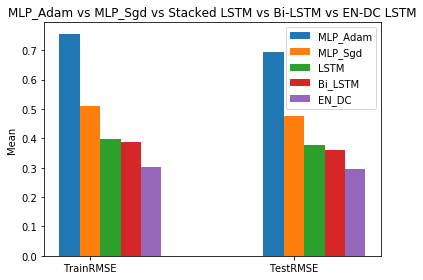

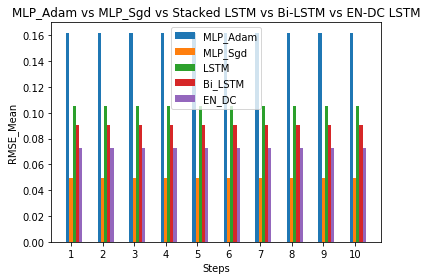

Rossler


/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.p

MODEL_FNN_adam
       TrainRMSE  TestRMSE
Exp1    0.600311  0.684728
Exp2    0.715471  0.802530
Exp3    0.725002  0.779865
Exp4    1.010173  1.060439
Exp5    0.645337  0.715744
Exp6    0.579463  0.662870
Exp7    0.515899  0.573356
Exp8    0.571888  0.655761
Exp9    1.027630  1.091890
Exp10   0.515598  0.583718
Exp11   0.999073  1.047866
Exp12   0.458592  0.523756
Exp13   0.545717  0.619284
Exp14   0.552470  0.617202
Exp15   0.551764  0.625681
Exp16   0.683184  0.728564
Exp17   0.736908  0.820608
Exp18   0.590070  0.666807
Exp19   1.055663  1.094841
Exp20   1.166799  1.213375
Exp21   0.616257  0.703626
Exp22   0.722583  0.792587
Exp23   0.602113  0.674146
Exp24   0.513704  0.591249
Exp25   0.757542  0.826441
Exp26   1.063569  1.119345
Exp27   0.837969  0.886201
Exp28   1.084482  1.128695
Exp29   0.899830  0.954956
Exp30   0.708810  0.784607
                Mean  Standard Deviation       Min       Max
TrainRMSE   0.735129            0.203857  0.458592  1.166799
TestRMSE    0.801025      

/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.p

MODEL_FNN_sgd
       TrainRMSE  TestRMSE
Exp1    0.636340  0.736126
Exp2    0.550200  0.638011
Exp3    0.595091  0.685676
Exp4    0.583666  0.673942
Exp5    0.631358  0.728933
Exp6    0.569745  0.659759
Exp7    0.514471  0.595356
Exp8    0.494646  0.571814
Exp9    0.547527  0.630563
Exp10   0.628448  0.727532
Exp11   0.558649  0.644109
Exp12   0.618457  0.713484
Exp13   0.565272  0.654575
Exp14   0.510613  0.591881
Exp15   0.577640  0.668795
Exp16   0.486414  0.562746
Exp17   0.519892  0.602151
Exp18   0.541132  0.621398
Exp19   0.524418  0.605339
Exp20   0.526053  0.606676
Exp21   0.527234  0.607322
Exp22   0.559077  0.646059
Exp23   0.586275  0.677464
Exp24   0.554348  0.639529
Exp25   0.533878  0.617321
Exp26   0.574335  0.662042
Exp27   0.527348  0.607181
Exp28   0.585552  0.676429
Exp29   0.639744  0.739558
Exp30   0.493793  0.568890
                Mean  Standard Deviation       Min       Max
TrainRMSE   0.558721            0.042887  0.486414  0.639744
TestRMSE    0.645355       

Experiment 1 in progress
Experiment 2 in progress
Experiment 3 in progress
Experiment 4 in progress
Experiment 5 in progress
Experiment 6 in progress
Experiment 7 in progress
Experiment 8 in progress
Experiment 9 in progress
Experiment 10 in progress
Experiment 11 in progress
Experiment 12 in progress
Experiment 13 in progress
Experiment 14 in progress
Experiment 15 in progress
Experiment 16 in progress
Experiment 17 in progress
Experiment 18 in progress
Experiment 19 in progress
Experiment 20 in progress
Experiment 21 in progress
Experiment 22 in progress
Experiment 23 in progress
Experiment 24 in progress
Experiment 25 in progress
Experiment 26 in progress
Experiment 27 in progress
Experiment 28 in progress
Experiment 29 in progress
MODEL_EN_DC
       TrainRMSE  TestRMSE
Exp1    0.636678  0.717262
Exp2    0.574644  0.653873
Exp3    0.534383  0.612302
Exp4    0.522346  0.599041
Exp5    0.511546  0.587128
Exp6    0.500851  0.575134
Exp7    0.490627  0.563398
Exp8    0.477863  0.548272


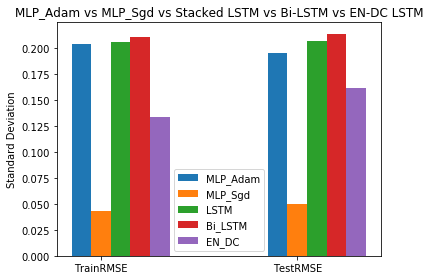

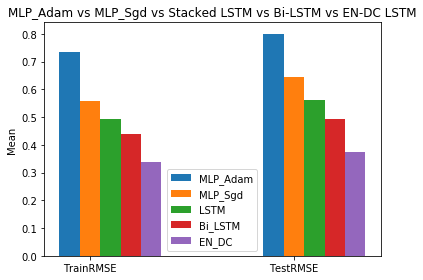

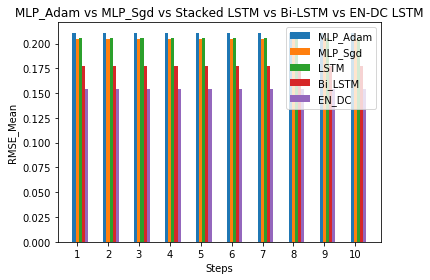

Henon


/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.p

/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MODEL_FNN_adam
       TrainRMSE  TestRMSE
Exp1    0.912207  0.904318
Exp2    0.743445  0.730533
Exp3    1.477300  1.482017
Exp4    0.722784  0.713561
Exp5    0.752092  0.749952
Exp6    0.735136  0.731070
Exp7    0.677604  0.667315
Exp8    0.741529  0.739371
Exp9    1.072588  1.073901
Exp10   0.830938  0.823155
Exp11   0.627817  0.624887
Exp12   1.103327  1.111762
Exp13   0.635039  0.621192
Exp14   0.643539  0.641422
Exp15   0.642196  0.636765
Exp16   0.797667  0.788300
Exp17   0.799881  0.799779
Exp18   0.853687  0.835135
Exp19   1.348964  1.352329
Exp20   0.672084  0.660572
Exp21   0.810473  0.802794
Exp22   0.644672  0.630714
Exp23   0.675108  0.668489
Exp24   0.687885  0.678646
Exp25   0.640083  0.635721
Exp26   0.804146  0.798892
Exp27   0.831707  0.815137
Exp28   1.233979  1.233542
Exp29   0.796463  0.794937
Exp30   0.995818  0.991972
                Mean  Standard Deviation       Min       Max
TrainRMSE   0.830339            0.214289  0.627817  1.477300
TestRMSE    0.824606      

/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.p

MODEL_FNN_sgd
       TrainRMSE  TestRMSE
Exp1    0.625031  0.597300
Exp2    0.606000  0.597548
Exp3    0.614657  0.604368
Exp4    0.597803  0.588324
Exp5    0.607544  0.590762
Exp6    0.611048  0.602161
Exp7    0.572196  0.564497
Exp8    0.635849  0.626269
Exp9    0.605186  0.587626
Exp10   0.624740  0.625279
Exp11   0.596538  0.592026
Exp12   0.609558  0.598099
Exp13   0.576474  0.567510
Exp14   0.602716  0.593219
Exp15   0.593302  0.588738
Exp16   0.639195  0.629659
Exp17   0.615545  0.604950
Exp18   0.603882  0.590459
Exp19   0.619315  0.599619
Exp20   0.627493  0.622896
Exp21   0.620093  0.615588
Exp22   0.611755  0.603898
Exp23   0.599525  0.584963
Exp24   0.608788  0.607855
Exp25   0.595036  0.583858
Exp26   0.633859  0.625448
Exp27   0.638305  0.639880
Exp28   0.635744  0.629732
Exp29   0.616773  0.607557
Exp30   0.574096  0.565303
                Mean  Standard Deviation       Min       Max
TrainRMSE   0.610602            0.017800  0.572196  0.639195
TestRMSE    0.601180       

Experiment 1 in progress
Experiment 2 in progress
Experiment 3 in progress
Experiment 4 in progress
Experiment 5 in progress
Experiment 6 in progress
Experiment 7 in progress
Experiment 8 in progress
Experiment 9 in progress
Experiment 10 in progress
Experiment 11 in progress
Experiment 12 in progress
Experiment 13 in progress
Experiment 14 in progress
Experiment 15 in progress
Experiment 16 in progress
Experiment 17 in progress
Experiment 18 in progress
Experiment 19 in progress
Experiment 20 in progress
Experiment 21 in progress
Experiment 22 in progress
Experiment 23 in progress
Experiment 24 in progress
Experiment 25 in progress
Experiment 26 in progress
Experiment 27 in progress
Experiment 28 in progress
Experiment 29 in progress
MODEL_EN_DC
       TrainRMSE  TestRMSE
Exp1    1.600548  1.606369
Exp2    0.775063  0.770813
Exp3    0.651158  0.642335
Exp4    0.614975  0.605628
Exp5    0.595142  0.585171
Exp6    0.587385  0.577370
Exp7    0.583330  0.573641
Exp8    0.580857  0.571608


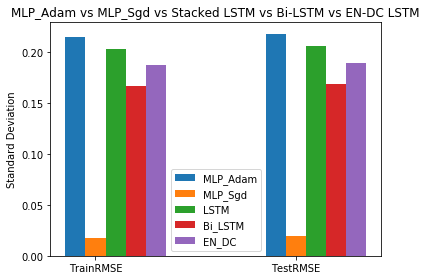

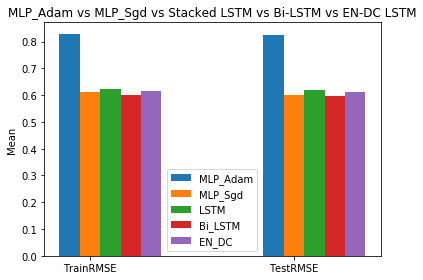

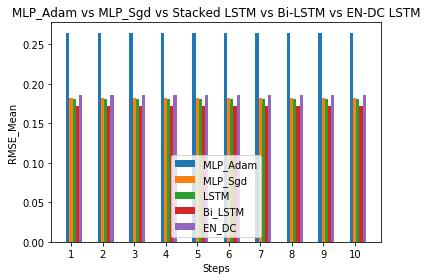

ACFinance


/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.p

MODEL_FNN_adam
       TrainRMSE  TestRMSE
Exp1    0.387303  0.513664
Exp2    0.475827  0.330731
Exp3    0.496398  0.234330
Exp4    1.008380  0.720193
Exp5    1.193497  0.942171
Exp6    0.370193  0.460242
Exp7    0.703454  0.634572
Exp8    0.783992  0.591811
Exp9    0.852334  0.717569
Exp10   0.662411  0.582982
Exp11   0.873775  0.704976
Exp12   0.436093  0.299037
Exp13   0.550405  0.465024
Exp14   1.284678  0.901546
Exp15   1.419514  0.901247
Exp16   1.021690  0.820172
Exp17   0.966319  0.591732
Exp18   0.762188  0.580268
Exp19   0.362416  0.422344
Exp20   1.279189  0.919945
Exp21   0.523265  0.465004
Exp22   1.117804  0.822903
Exp23   1.192988  0.856521
Exp24   0.979797  0.580791
Exp25   1.272542  0.856725
Exp26   0.702602  0.487531
Exp27   0.989940  0.805603
Exp28   0.875113  0.674027
Exp29   1.249732  0.859289
Exp30   0.549889  0.490369
                Mean  Standard Deviation       Min       Max
TrainRMSE   0.844791            0.313237  0.362416  1.419514
TestRMSE    0.641111      

/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.p

/Users/shauryagoyal32/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MODEL_FNN_sgd
       TrainRMSE  TestRMSE
Exp1    0.297261  0.328500
Exp2    0.330696  0.383110
Exp3    0.452223  0.549535
Exp4    0.338490  0.382261
Exp5    0.308028  0.342835
Exp6    0.346130  0.395735
Exp7    0.397982  0.477873
Exp8    0.395491  0.482197
Exp9    0.329358  0.399778
Exp10   0.320524  0.376733
Exp11   0.339809  0.409279
Exp12   0.603680  0.630493
Exp13   0.457664  0.563439
Exp14   0.356734  0.418925
Exp15   0.423617  0.508415
Exp16   0.308703  0.351900
Exp17   0.420543  0.501202
Exp18   0.327361  0.389598
Exp19   0.318189  0.361058
Exp20   0.395043  0.480391
Exp21   0.581527  0.688773
Exp22   0.424438  0.518121
Exp23   0.362197  0.417568
Exp24   0.428879  0.523759
Exp25   0.565299  0.655765
Exp26   0.390125  0.466531
Exp27   0.604702  0.628523
Exp28   0.405243  0.489739
Exp29   0.475793  0.581679
Exp30   0.396495  0.473964
                Mean  Standard Deviation       Min       Max
TrainRMSE   0.403407            0.086938  0.297261  0.604702
TestRMSE    0.472589       

Experiment 1 in progress
Experiment 2 in progress
Experiment 3 in progress
Experiment 4 in progress
Experiment 5 in progress
Experiment 6 in progress
Experiment 7 in progress
Experiment 8 in progress
Experiment 9 in progress
Experiment 10 in progress
Experiment 11 in progress
Experiment 12 in progress
Experiment 13 in progress
Experiment 14 in progress
Experiment 15 in progress
Experiment 16 in progress
Experiment 17 in progress
Experiment 18 in progress
Experiment 19 in progress
Experiment 20 in progress
Experiment 21 in progress
Experiment 22 in progress
Experiment 23 in progress
Experiment 24 in progress
Experiment 25 in progress
Experiment 26 in progress
Experiment 27 in progress
Experiment 28 in progress
Experiment 29 in progress
MODEL_EN_DC
       TrainRMSE  TestRMSE
Exp1    1.521669  0.837050
Exp2    0.798854  0.420972
Exp3    0.673609  0.339792
Exp4    0.519771  0.303956
Exp5    0.448976  0.262843
Exp6    0.416524  0.235452
Exp7    0.387430  0.212585
Exp8    0.362701  0.195204


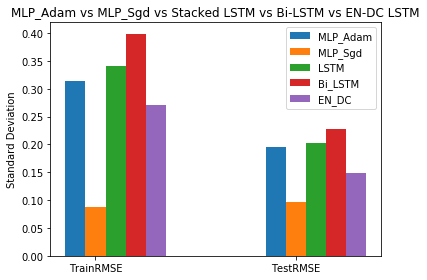

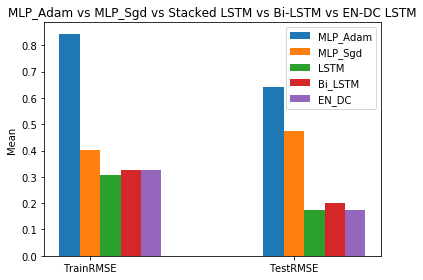

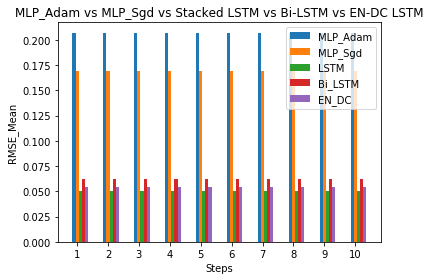

      Dataset        Method       TrainRMSE_Mean         TrainRMSE_Std  \
0       Lazer      MLP_Adam   0.7217142868756417   0.11973074271332225   
1       Lazer       MLP_Sgd   0.6440130760005459   0.02831689308202628   
2       Lazer  Stacked_LSTM    0.431433742501151    0.1239003302800833   
3       Lazer       Bi-LSTM  0.40989608587610454   0.11959309342881722   
4       Lazer    EN-DC LSTM   0.5083775324638419   0.10924839051666785   
5     Sunspot      MLP_Adam   0.7227627431302888    0.1996093968062549   
6     Sunspot       MLP_Sgd   0.5642521647177271   0.10663791177854283   
7     Sunspot  Stacked_LSTM  0.44237008616022705   0.18526315860795167   
8     Sunspot       Bi-LSTM   0.3978905213556157    0.1315847019860735   
9     Sunspot    EN-DC LSTM    0.377502987369247    0.1523793251990687   
10     Mackey      MLP_Adam   0.6250689050163738    0.2714352530295015   
11     Mackey       MLP_Sgd   0.3046134988347651  0.018086754900771503   
12     Mackey  Stacked_LSTM  0.2945533

In [43]:
def main():
    
    n_steps_in, n_steps_out = 5,10
    
    Overall_Analysis=np.zeros([35,36])
    for i in range(1,8):
        problem=i
        if problem ==1:
            TrainData = pd.read_csv("../data/Lazer/train1.csv",index_col = 0)
            TrainData = TrainData.values
            TestData = pd.read_csv("../data/Lazer/test1.csv",index_col = 0)
            TestData = TestData.values
            name= "Lazer"
        if problem ==2:
            TrainData = pd.read_csv("../data/Sunspot/train1.csv",index_col = 0)
            TrainData = TrainData.values
            TestData = pd.read_csv("../data/Sunspot/test1.csv",index_col = 0)
            TestData = TestData.values
            name= "Sunspot"
        if problem ==3:
            TrainData = pd.read_csv("../data/Mackey/train1.csv",index_col = 0)
            TrainData = TrainData.values
            TestData = pd.read_csv("../data/Mackey/test1.csv",index_col = 0)
            TestData = TestData.values
            name="Mackey"
        if problem ==4:
            TrainData = pd.read_csv("../data/Lorenz/train1.csv",index_col = 0)
            TrainData = TrainData.values
            TestData = pd.read_csv("../data/Lorenz/test1.csv",index_col = 0)
            TestData = TestData.values  
            name= "Lorenz"
        if problem ==5:
            TrainData = pd.read_csv("../data/Rossler/train1.csv",index_col = 0)
            TrainData = TrainData.values
            TestData = pd.read_csv("../data/Rossler/test1.csv",index_col = 0)
            TestData = TestData.values
            name= "Rossler"
        if problem ==6:
            TrainData = pd.read_csv("../data/Henon/train1.csv",index_col = 0)
            TrainData = TrainData.values
            TestData = pd.read_csv("../data/Henon/test1.csv",index_col = 0)
            TestData = TestData.values
            name= "Henon"
        if problem ==7:
            TrainData = pd.read_csv("../data/ACFinance/train1.csv",index_col = 0)
            TrainData = TrainData.values
            TestData = pd.read_csv("../data/ACFinance/test1.csv",index_col = 0)
            TestData = TestData.values
            name= "ACFinance" 

        x_train = TrainData[:,0:5]
        y_train = TrainData[:,5:15]
        x_test = TestData[:,0:5]
        y_test = TestData[:,5:15]

        print(name)

        TrainRMSE_mean=np.zeros(5)
        TestRMSE_mean=np.zeros(5)
        TrainRMSE_Std=np.zeros(5)
        TestRMSE_Std=np.zeros(5)
        Step_RMSE_mean=np.zeros([5,10])
        train_acc=np.zeros(30)
        test_acc=np.zeros(30)
        Step_RMSE=np.zeros([30,10])


        for k in range(1,6):

            method=k
            if method ==1:
                train_acc,test_acc,Step_RMSE=MODEL_FNN_adam(x_train,x_test,y_train,y_test)
                Mname="MODEL_FNN_adam"
            if method ==2:
                train_acc,test_acc,Step_RMSE=MODEL_FNN_sgd(x_train,x_test,y_train,y_test)
                Mname="MODEL_FNN_sgd"
            if method ==3:
                train_acc,test_acc,Step_RMSE=MODEL_LSTM(x_train,x_test,y_train,y_test)
                Mname="MODEL_LSTM"
            if method ==4:
                train_acc,test_acc,Step_RMSE=MODEL_Bi_LSTM(x_train,x_test,y_train,y_test)
                Mname="MODEL_Bi_LSTM"
            if method ==5:
                train_acc,test_acc,Step_RMSE=MODEL_EN_DC(x_train,x_test,y_train,y_test)
                Mname="MODEL_EN_DC"

            print(Mname)

            Overall_Analysis[(i-1)*5+(k-1)][0]=np.mean(train_acc)
            Overall_Analysis[(i-1)*5+(k-1)][1]=np.std(train_acc)
            Overall_Analysis[(i-1)*5+(k-1)][2]=np.min(train_acc)
            Overall_Analysis[(i-1)*5+(k-1)][3]=np.mean(test_acc)
            Overall_Analysis[(i-1)*5+(k-1)][4]=np.std(test_acc)
            Overall_Analysis[(i-1)*5+(k-1)][5]=np.min(test_acc)



            arr = np.dstack((train_acc,test_acc))
            arr=arr.reshape(30,2)
            arr = pd.DataFrame(arr, index = [ 'Exp1','Exp2','Exp3','Exp4','Exp5','Exp6','Exp7','Exp8','Exp9','Exp10','Exp11','Exp12','Exp13','Exp14','Exp15','Exp16','Exp17','Exp18','Exp19','Exp20','Exp21','Exp22','Exp23','Exp24','Exp25','Exp26','Exp27','Exp28','Exp29','Exp30'], columns=['TrainRMSE','TestRMSE'])
            arr.to_csv("Results/"+name+"/"+Mname+"/ExpAnalysis.csv")
            print(arr)
            TrainRMSE_mean[k-1]=np.mean(train_acc)
            TestRMSE_mean[k-1]=np.mean(test_acc)
            TrainRMSE_Std[k-1]=np.std(train_acc)
            TestRMSE_Std[k-1]=np.std(test_acc)

            for j in range(10):
                Step_RMSE_mean[k-1][j]=np.mean(Step_RMSE[:,j])

            arr1 = np.vstack(([np.mean(train_acc),np.std(train_acc),np.min(train_acc),np.max(train_acc)],[np.mean(test_acc), np.std(test_acc),np.min(test_acc),np.max(test_acc)]))
            for j in range(10):
                Step_mean = np.mean(Step_RMSE[:,j])
                Step_std = np.std(Step_RMSE[:,j])
                Step_min = np.min(Step_RMSE[:,j])
                arr1=np.vstack((arr1,[Step_mean,Step_std,Step_min,np.max(Step_RMSE[:,j])]))
                Overall_Analysis[(i-1)*5+(k-1)][3*j+6]= Step_mean
                Overall_Analysis[(i-1)*5+(k-1)][3*j+7]= Step_std
                Overall_Analysis[(i-1)*5+(k-1)][3*j+8]= Step_min
            arr1 = pd.DataFrame(arr1, index=['TrainRMSE','TestRMSE','Step1RMSE','Step2RMSE','Step3RMSE','Step4RMSE','Step5RMSE','Step6RMSE','Step7RMSE','Step8RMSE','Step9RMSE','Step10RMSE'], columns = ['Mean','Standard Deviation','Min','Max'])
            print(arr1)
            arr1.to_csv("Results/"+name+"/"+Mname+"/OverallAnalysis.csv")


        labels = ['TrainRMSE_Std','TestRMSE_Std']
        MLP_Adam=[TrainRMSE_Std[0],TestRMSE_Std[0]]
        MLP_Sgd=[TrainRMSE_Std[1],TestRMSE_Std[1]]
        LSTM=[TrainRMSE_Std[2],TestRMSE_Std[2]]
        Bi_LSTM=[TrainRMSE_Std[3],TestRMSE_Std[3]]
        EN_DC=[TrainRMSE_Std[4],TestRMSE_Std[4]]
        width = 0.1  # the width of the bars
        r1 = np.arange(len(labels))
        r2 = [x + width for x in r1]
        r3 = [x + width for x in r2]
        r4 = [x + width for x in r3]
        r5 = [x + width for x in r4]

        fig, ax = plt.subplots()
        rects1 = ax.bar(r1, MLP_Adam, width, label='MLP_Adam')
        rects2 = ax.bar(r2, MLP_Sgd, width, label='MLP_Sgd')
        rects3 = ax.bar(r3, LSTM, width, label='LSTM')
        rects4 = ax.bar(r4, Bi_LSTM, width, label='Bi_LSTM')
        rects5 = ax.bar(r5, EN_DC, width, label='EN_DC')

        plt.ylabel("Standard Deviation")
        ax.set_title('MLP_Adam vs MLP_Sgd vs Stacked LSTM vs Bi-LSTM vs EN-DC LSTM')
        plt.xticks([r + width for r in range(len(MLP_Adam))], ['TrainRMSE', 'TestRMSE'])
        ax.legend()
        fig.tight_layout()
        plt.savefig("Results/"+name+"/"+"Train&Test_RMSE_Std_Comparison.png",dpi=100)
        plt.show()


        labels = ['TrainRMSE_mean','TestRMSE_mean']
        MLP_Adam=[TrainRMSE_mean[0],TestRMSE_mean[0]]
        MLP_Sgd=[TrainRMSE_mean[1],TestRMSE_mean[1]]
        LSTM=[TrainRMSE_mean[2],TestRMSE_mean[2]]
        Bi_LSTM=[TrainRMSE_mean[3],TestRMSE_mean[3]]
        EN_DC=[TrainRMSE_mean[4],TestRMSE_mean[4]]
        width = 0.1  # the width of the bars
        r1 = np.arange(len(labels))
        r2 = [x + width for x in r1]
        r3 = [x + width for x in r2]
        r4 = [x + width for x in r3]
        r5 = [x + width for x in r4]

        fig, ax = plt.subplots()
        rects1 = ax.bar(r1, MLP_Adam, width, label='MLP_Adam')
        rects2 = ax.bar(r2, MLP_Sgd, width, label='MLP_Sgd')
        rects3 = ax.bar(r3, LSTM, width, label='LSTM')
        rects4 = ax.bar(r4, Bi_LSTM, width, label='Bi_LSTM')
        rects5 = ax.bar(r5, EN_DC, width, label='EN_DC')

        plt.ylabel("Mean")
        ax.set_title('MLP_Adam vs MLP_Sgd vs Stacked LSTM vs Bi-LSTM vs EN-DC LSTM')
        plt.xticks([r + width for r in range(len(MLP_Adam))], ['TrainRMSE', 'TestRMSE'])
        ax.legend()
        fig.tight_layout()
        plt.savefig("Results/"+name+"/"+"Train&Test_RMSE_mean_Comparison.png",dpi=100)
        plt.show()


        MLP_Adam=np.zeros(10)
        MLP_Sgd=np.zeros(10)
        LSTM=np.zeros(10)
        Bi_LSTM=np.zeros(10)
        EN_DC=np.zeros(10)
        labels = ['Step1','Step2','Step3','Step4','Step5','Step6','Step7','Step8','Step9','Step10']
        for j in range(10):
            MLP_Adam=Step_RMSE_mean[0][j]
            MLP_Sgd=Step_RMSE_mean[1][j]
            LSTM=Step_RMSE_mean[2][j]
            Bi_LSTM=Step_RMSE_mean[3][j]
            EN_DC=Step_RMSE_mean[4][j]
        width = 0.1  # the width of the bars
        r1 = np.arange(len(labels))
        r2 = [x + width for x in r1]
        r3 = [x + width for x in r2]
        r4 = [x + width for x in r3]
        r5 = [x + width for x in r4]

        fig, ax = plt.subplots()
        rects1 = ax.bar(r1, MLP_Adam, width, label='MLP_Adam')
        rects2 = ax.bar(r2, MLP_Sgd, width, label='MLP_Sgd')
        rects3 = ax.bar(r3, LSTM, width, label='LSTM')
        rects4 = ax.bar(r4, Bi_LSTM, width, label='Bi_LSTM')
        rects5 = ax.bar(r5, EN_DC, width, label='EN_DC')

        plt.ylabel("RMSE_Mean")
        plt.xlabel("Steps")
        ax.set_title('MLP_Adam vs MLP_Sgd vs Stacked LSTM vs Bi-LSTM vs EN-DC LSTM')
        plt.xticks([r + width for r in range(10)], ['1','2','3','4','5','6','7','8','9','10'])
        ax.legend()
        fig.tight_layout()
        plt.savefig("Results/"+name+"/"+"StepRMSE_Comparison.png",dpi=100)
        plt.show()
    
    Index1=['MLP_Adam','MLP_Sgd','Stacked_LSTM','Bi-LSTM','EN-DC LSTM']
    Column=['Dataset','Method','TrainRMSE_Mean','TrainRMSE_Std','TrainRMSE_Min','TestRMSE_Mean','TestRMSE_Std','TestRMSE_Min']
    for j in range(1,11):
        Column=np.concatenate((Column, ['Step'+str(j)+'RMSE_Mean','Step'+str(j)+'RMSE_Std','Step'+str(j)+'RMSE_Min']))
    for j in range(6):
        Index1=np.concatenate((Index1, ['MLP_Adam','MLP_Sgd','Stacked_LSTM','Bi-LSTM','EN-DC LSTM']))
    Index2=["Lazer","Lazer","Lazer","Lazer","Lazer","Sunspot","Sunspot","Sunspot","Sunspot","Sunspot","Mackey","Mackey","Mackey","Mackey","Mackey","Lorenz","Lorenz","Lorenz","Lorenz","Lorenz","Rossler","Rossler","Rossler","Rossler","Rossler","Henon","Henon","Henon","Henon","Henon","ACFinance","ACFinance","ACFinance","ACFinance","ACFinance"]
    Index=np.dstack((Index2,Index1))
    Index=Index.reshape(35,2)
    Overall_Analysis=np.concatenate((Index,Overall_Analysis), axis=1)
    Overall_Analysis = pd.DataFrame(Overall_Analysis, columns = Column)
    print(Overall_Analysis)
    Overall_Analysis.to_csv("Results/OverallAnalysis.csv")
    
    
    
if __name__ == "__main__": main()